In [212]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from mia.shadow_models import *
from mia.attack_model import *
from mia.utilities import *
from mia.wrappers import *

from tqdm import tqdm
import sys
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


## Data Preprocessing, D_in & D_out and Target Model Creation

OK. Let's first load our dataset and take a peek at the data.

In [213]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

--2022-01-15 11:25:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.1’

adult.data.1        100%[===================>]   3.79M  7.37MB/s    in 0.5s    

2022-01-15 11:25:14 (7.37 MB/s) - ‘adult.data.1’ saved [3974305/3974305]



In [214]:
cols = ['age', 
        'workclass', 
        'fnlwgt', 
        'education',
        'education-num',
        'marital-status',
        'occupation', 
        'relationship', 
        'race',
        'sex',
        'capital-gain',
        'capital-loss',
        'hours-per-week', 
        'native-country',
        'salary']
cat_cols = [
  'workclass', 
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'     
]

num_cols = list(set(cols) - set(cat_cols) - set({'salary'}))

In [215]:
dataset_path = 'adult.data' 

In [216]:
data_df = pd.read_csv(dataset_path, index_col=False, names=cols)

In [217]:
data_df.loc[data_df['salary'].str.contains('>50K'), 'salary'] = 1
data_df.loc[data_df['salary'].str.contains('>50K') == False, 'salary'] = 0

In [218]:
for col in cat_cols:
  data_df = data_df[data_df[col].str.contains('\?') == False]

In [219]:
data_df[cat_cols] = data_df[cat_cols].astype('category')
for col in cat_cols:
  data_df[col] = data_df[col].cat.codes

In [220]:
y = data_df.pop('salary').to_numpy(dtype=np.int8)
X = data_df.to_numpy(dtype=np.float64) 

In [221]:
# divide to target and attack dataset
X_target, X_attacker, y_target, y_attacker = train_test_split(X, y, test_size=0.5, shuffle=True, random_state=0)

# train-test split for the target
X_train, X_test, y_train, y_test = train_test_split(X_target, y_target, test_size=0.33, shuffle=True, random_state=0)

In [222]:
target_model = DecisionTreeClassifier(random_state=0).fit(X_train, y_train.reshape(-1))

In [223]:
print('Training Test Scores:', 
      classification_report(y_train, target_model.predict(X_train)), 
      'Validation Test Scores:', 
      classification_report(y_test, target_model.predict(X_test)), sep='\n')

Training Test Scores:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7625
           1       1.00      1.00      1.00      2479

    accuracy                           1.00     10104
   macro avg       1.00      1.00      1.00     10104
weighted avg       1.00      1.00      1.00     10104

Validation Test Scores:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3734
           1       0.60      0.62      0.61      1243

    accuracy                           0.80      4977
   macro avg       0.74      0.74      0.74      4977
weighted avg       0.80      0.80      0.80      4977



In [224]:
target_model.predict = target_model.predict_proba

So we clearly see that Decision tree is overfitted to the data. It is time to run our normal attack on some data that lack of certain features.

## Attacker-Shadows Dataset separation

We will divide the attacker dataset to
- Attack Evaluation dataset of instances that we know they belong to $D_{out}$
- Attack Evaluation dataset of instances that we know they belong to $D_{in}$
- Instances from the dataset distribution we will use to train the shadow and attack models. These will also be used as a guide to fill out null values later.



In [225]:
# divide attacker dataset
X_attacker_train, X_attacker_test_out, y_attacker_train, y_attacker_test_out = train_test_split(X_attacker, y_attacker, test_size=0.33, shuffle=True, random_state=0)

# get a proportion of the D_in dataset for later testing of the model
_, X_attacker_test_in, _, y_attacker_test_in = train_test_split(X_train, y_train, test_size=0.33, shuffle=True, random_state=0)


## Standard Attack
Perform Standard Attack to get point of reference.

In [226]:
def f_shadow():
  model = RandomForestClassifier(random_state=0) 
  model.predict = model.predict_proba
  return  model

In [227]:
def f_attack():
    model = RandomForestClassifier(random_state=0)
    model.predict = model.predict_proba
    return model 


In [228]:
ConfidenceVectorAttack.SHADOW_MODEL_TYPE = 'sklearn'
ConfidenceVectorAttack.ATTACK_MODEL_TYPE = 'sklearn'
default_attack = ConfidenceVectorAttack(
    target_model=target_model,
    target_dataset=(X_attacker_test_in, y_attacker_test_in),
    attacker_dataset=(X_attacker_train, y_attacker_train),
    attack_model_creator=f_attack,
    shadow_creator=f_shadow,
    n_shadows=10,
    D_shadow_size=5000, 
    verbose=True)


In [229]:
default_attack.perform_attack()

Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!


              precision    recall  f1-score   support

         0.0       1.00      0.20      0.33      3335
         1.0       0.55      1.00      0.71      3335

    accuracy                           0.60      6670
   macro avg       0.78      0.60      0.52      6670
weighted avg       0.78      0.60      0.52      6670

AUC: 0.6184052201785164


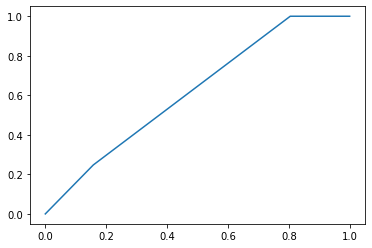

In [230]:
D_in = attack_model.prepare_batch(target_model, X_attacker_test_in, y_attacker_test_in, True)
D_out = attack_model.prepare_batch(target_model, X_attacker_test_out[:3335], y_attacker_test_out[:3335], False)
D_all = np.concatenate((D_in, D_out))
default_attack.attack_model.evaluate(D_all[:, :-1], D_all[:, -1], verbose=1)

## Filling null features from the dataset distribution.

For research purposes we will cross out some categorical and numerical datapoints with probability of 10\%$ and fill them using the following methods:

- for numerical features use the mean of the collumn
- for categorical features, find the label, group by it, find the most common value, accross same-labeled instances and assign it to the null case.

In [231]:
""" 
    Routine that treats features of all records as null with prob @prob_of_null.
    If feature is categorical we will replace it with most used value given the label
    If numeric we will replace it with the mean among the dataset of record with the same value
"""
def fill_out_missing_values(df, cat_cols, num_cols, y_label, prob_of_null = 0.15):
  y_labels = df[y_label].unique().tolist()
  
  # create a most used values and mean values array based on the class and the column
  value_mapper = {}
  
  for i in y_labels:
    values = {}
    for col in cat_cols:
      values[col] = df.loc[df[y_label] == i, col].mode()[0]
      
    for col in num_cols:
      values[col] = df.loc[df[y_label] == i, col].mean(axis=0)
      
    value_mapper[i] = values

  for i in y_labels:
    for col in cat_cols+num_cols:
      df.loc[df[y_label] == i, col] = df.loc[df[y_label] == i, col].apply(lambda x: x if np.random.random() - prob_of_null >= 0.0 else value_mapper[i][col])
      
  return df

In [232]:
df = pd.DataFrame(np.concatenate((X_attacker_test_out, y_attacker_test_out.reshape(-1, 1)), axis=1), columns=cols)

In [233]:
df_out = fill_out_missing_values(df, cat_cols, num_cols, 'salary')
y_attacker_test_out = df_out.pop('salary').to_numpy()
X_attacker_test_out = df_out.to_numpy()

In [234]:
df = pd.DataFrame(np.concatenate((X_attacker_test_in, y_attacker_test_in.reshape(-1, 1)), axis=1), columns=cols)

In [235]:
df_in = fill_out_missing_values(df, cat_cols, num_cols, 'salary')
y_attacker_test_in = df_in.pop('salary').to_numpy()
X_attacker_test_in = df_in.to_numpy()

In [236]:
N_SHADOWS= 10
SHADOW_EPOCHS=50
SHADOW_DATASET_SIZE= 5000


In [237]:
shadow_models = ShadowModelBatch(N_SHADOWS, f_shadow, model_type='sklearn')

In [238]:
D_shadows = generate_shadow_dataset(target_model, N_SHADOWS, SHADOW_DATASET_SIZE, 2, attacker_X=X_attacker_train, attacker_y=y_attacker_train)

In [239]:
ShadowModelBatch.VERBOSE=True
shadow_models.fit_all(D_shadows, SHADOW_EPOCHS)

In [240]:
attack_model = DefaultAttackModel(shadow_models, 2, f_attack)

In [241]:
DefaultAttackModel.VERBOSE = True
attack_model.fit(epochs=50)

Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!
Preparing shadow batch of size 3300
Done!


              precision    recall  f1-score   support

         0.0       0.73      0.22      0.34      3335
         1.0       0.54      0.92      0.68      3335

    accuracy                           0.57      6670
   macro avg       0.63      0.57      0.51      6670
weighted avg       0.63      0.57      0.51      6670

AUC: 0.5745963150358853


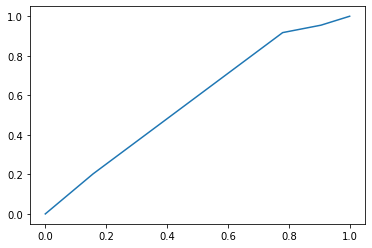

In [242]:
D_in = attack_model.prepare_batch(target_model, X_attacker_test_in, y_attacker_test_in, True)
D_out = attack_model.prepare_batch(target_model, X_attacker_test_out[:3335], y_attacker_test_out[:3335], False)
D_all = np.concatenate((D_in, D_out))
attack_model.evaluate(D_all[:, :-1], D_all[:, -1], verbose=1)

## Experimental Results

### Best hyperparameter tuning 

After some testing we note that out attack will perform well when we supply it with 5 to 10 shadow models with 5000-10000 training instances, per shadow model.

Note that we tried the following tuning settings:
- 5 to 20 shadows, 1000 samples, could not achieve over 50\% accuracy
- 10 to 20 shadows, 5000 samples, achieved a max of 54\% accuracy and best recall and precision  for $x \in D_{target}$ with precision of 1.0 and recall of 0.70
- 5 to 10 shadows, 10000 samples, yielded same results as the runs with 5000


### Notes about Attack and shadows architecture
Also our attack will perform better if we manage to use and ensemble model, like a random forest, to perform the final attack than a normal classifier. The closer the model behaves to the original target the closer we get to a better attack

### Conclusion
Trying different values for the percentage of lost/missing values per record we can notice a decrease in attack performance (accuracy and precision fall) that means: 
We can execute the attack with missing values, but we should consider a larger error margin in our inference predictions. 

Using 10 shadows with 5000 instances for training we yielded the following results, with respect to missing values percentage across the testing dataset and attack performance on this dataset:

|Missing Values \% | F-1 Score | Presicion | Recall | 
| --- | --- | --- | --- |
| 0% | .60 | .78 | .60 |
| 1\% | .59 | .75 | .59 |
| 5\% | .58 | .70 | .58|
| 10\% | .57| .67| .57|
| 15\% | .57| .63| .57|
| 20\% | .56| .62 | .56 |
